In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
import pandas as pd
from pandas import ExcelWriter
from pandas import ExcelFile
from scipy import stats
import sample_utils

%matplotlib inline

# TRUE DATA
#### REQUIRED: 2020_LER_20200804_V006.xlsx' file

In [138]:
name = '2020_LER_20200922_V007_testset_edit.csv'
datatype = 'n'

dataset = sample_utils.get_dataset(name, datatype)
num_in_cycle = 50

# real
real = dataset.test_Y

# y mean and std
y_mean = np.mean(dataset.train_Y, axis=0, dtype=np.float32)
y_std = np.std(dataset.train_Y, axis=0, dtype=np.float32)

test_num = int(real.shape[0]/num_in_cycle)

============ Data load =============
STEP 1: CHECK DATA SIZE
X data shape:  (11800, 5) X per cycle data shape: (236, 5)
Y data shape:  (11800, 6) Y per cycle data shape: (236, 6)
STEP 2: CHECK NAN DATA
any nan in X?:  []
any nan in Y?:  [[ 4450     0]
 [ 4450     1]
 [ 4450     2]
 ...
 [11799     3]
 [11799     4]
 [11799     5]]

============= Data split ==============
STEP1: split All data
Same number of x data and y data
train X: (4400, 5) train Y: (4400, 6)
val X: (750, 5) val Y: (750, 6)
test X: (750, 5) test Y: (750, 6)
x mean, std:  [  0.4169446  52.178642  121.815414    1.          0.       ] [ 0.20426613 26.91275    53.589043    0.          0.        ]
y mean, std:  [2.2097402e-12 4.1623207e-05 1.6310687e-05 3.4307730e-01 3.5102329e-01
 6.1670391e+01] [7.7363783e-13 2.1860972e-06 8.3510133e-07 7.4649407e-03 6.7155589e-03
 3.2870254e-01]

STEP2: split cycle data
Same number of x data and y data
train X: (88, 5) train Y: (88, 6)
val X: (15, 5) val Y: (15, 6)
test X: (15, 5) tes

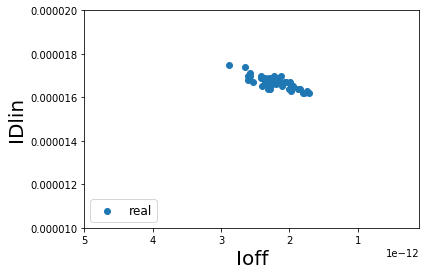

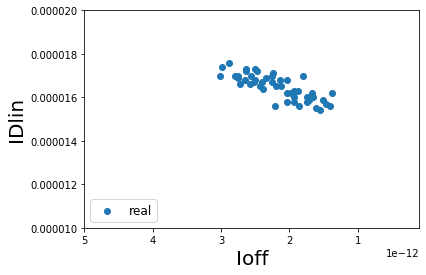

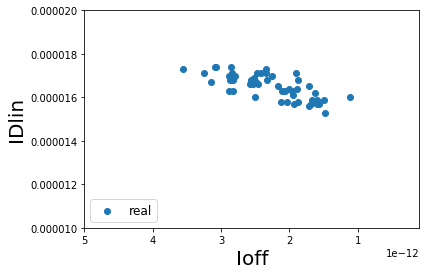

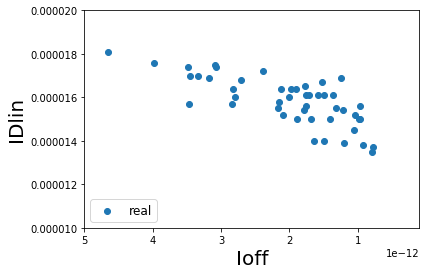

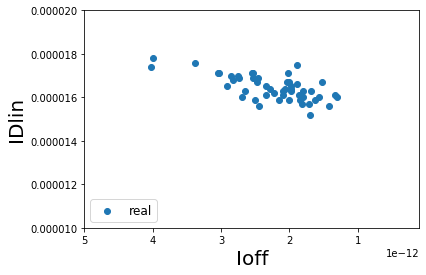

In [139]:
# TEST SET Visualize


import pandas as pd
import numpy as np

############################################## CHANGE HERE ######################################################

# factor : test set index ( hard ones: 2 3 7 12 14 )
factor_list = [2, 3, 7, 12, 14]

#################################################################################################################

for i in range(len(factor_list)):
    start = num_in_cycle * factor_list[i]
    end = num_in_cycle * (factor_list[i]+1)

    plt.scatter(dataset.test_Y[start:end,0],dataset.test_Y[start:end,2], label='real')
    plt.xlim(5e-12, 1e-13)
    plt.ylim(1e-5, 2e-5)
    plt.legend(loc='lower left', fontsize=12)
    plt.xlabel("Ioff", fontsize=20)
    plt.ylabel("IDlin", fontsize=20)
    plt.show()

# GENERATED DATA

#### required: generated sample in 'npy' file 
#### in ( test_num * sample_num, 6 ) shape 

In [140]:

############################################### CHANGE HERE ##################################################

# type your result name

total_name = 'total_date_20200927_data_n_model_mlp_gan1_seed_0_lr_5e-05_0.0001_0.0005_hidden_dim_100_50_batch_size_32_epoch_1000_200_noise_d_100_sample_num_250_pdrop_0.9.npy'

##############################################################################################################

total_result = np.load(total_name, allow_pickle=True)

sample_num = int(len(total_result)/test_num)
print("GENERATED SAMPLE shape: ",total_result.shape)
print("GENERATED SAMPLE NUM:", sample_num)

# checking nan value
print("any nan in real?: ", np.argwhere(np.isnan(real)))
print("any nan in generated?: ", np.argwhere(np.isnan(total_result)))



GENERATED SAMPLE shape:  (3750, 6)
GENERATED SAMPLE NUM: 250
any nan in real?:  []
any nan in generated?:  []


# FID SCORE 

In [141]:
score, FID_score_list = sample_utils.FID_score_each_X((total_result-y_mean) / y_std, (real - y_mean) / y_std, num_in_gen=sample_num, num_in_cycle=num_in_cycle)
print('FID_score_mean', score)
for i in range(len(FID_score_list)):
    print("FID_score for each X factor {}: {}".format(i, FID_score_list[i]))

    
y_min = np.min(np.array([np.min(real, axis=0), np.min(total_result, axis=0)]), axis=0)
y_max = np.max(np.array([np.max(real, axis=0), np.max(total_result, axis=0)]), axis=0)
EMD_score, EMD_score_list = sample_utils.EMD_each_X((total_result-y_min) / (y_max-y_min), (real - y_min) / (y_max-y_min), num_in_gen=sample_num, num_in_cycle=num_in_cycle)
print('EMD_score_mean', EMD_score)
for i in range(len(EMD_score_list)):
    print("EMD for each X factor {}: {}".format(i, EMD_score_list[i]))
# A: Ioff, B: IDSat, C: IDlin, D: VTsat, E:VTlin, F:SS, G: classs


FID_score_mean 0.36552004746522304
FID_score for each X factor 0: 0.045535796852767055
FID_score for each X factor 1: 0.6038415449587721
FID_score for each X factor 2: 0.04565679093195353
FID_score for each X factor 3: 0.11452026767808225
FID_score for each X factor 4: 0.0642936084811834
FID_score for each X factor 5: 0.12454641732749008
FID_score for each X factor 6: 0.7105675133759759
FID_score for each X factor 7: 0.18601466299443428
FID_score for each X factor 8: 0.3444849109755388
FID_score for each X factor 9: 0.5253186675537783
FID_score for each X factor 10: 1.1571795329249346
FID_score for each X factor 11: 0.6862521164413837
FID_score for each X factor 12: 0.5365153698138677
FID_score for each X factor 13: 0.16223855434746032
FID_score for each X factor 14: 0.17583495732072305
EMD_score_mean 0.009464071411639453
EMD for each X factor 0: 0.0030735619366168976
EMD for each X factor 1: 0.017198093235492706
EMD for each X factor 2: 0.0046805087476968765
EMD for each X factor 3: 0

# FEATURE DISTRIBUTION



In [146]:
import pandas as pd
import numpy as np

############################################### CHANGE HERE ##################################################

# type the X index of test sample ( 0 ~ 14) ( hard ones: 2 3 7 12 14 )

factor = 2

##############################################################################################################
"""
for i in range(6):
    print(np.min(total_result[:,i]))
    print(np.max(total_result[:,i]))
    print(np.min(real[:,i]))
    print(np.max(real[:,i]))
"""

# generated sample
gan_matrix_plot = total_result[factor * sample_num:(factor+1)*sample_num]
print("Generated sample shape:", gan_matrix_plot.shape)

# real sample
real_matrix_plot = real[factor * num_in_cycle:(factor+1)*num_in_cycle]
print("real sample shape:", real_matrix_plot.shape)
print()

# Assigning class(generated: 0, real:1 ) for visualization

print("Assigning class for visualization (generated: 0, real:1 )")

gan_cls = np.zeros((sample_num, 1))
print("generated sample class shape:", gan_cls.shape)
real_cls = np.ones((50, 1))
print("real sample class shape:", real_cls.shape)

temp1 = np.hstack([gan_matrix_plot, gan_cls])
temp2 = np.hstack([real_matrix_plot, real_cls])

# TOTAL PANDAS DATA
total_matrix_plot = np.vstack([temp1, temp2])
# print(total_matrix_plot.shape)

# A: Ioff, B: IDSat, C: IDlin, D: VTsat, E:VTlin, F:SS, G: classes
df1 = pd.DataFrame(total_matrix_plot, columns=['Ioff', 'IDSat',  'IDlin',  'VTsat', 'VTlin', 'SS', 'classes'])
# print(df1)


Generated sample shape: (250, 6)
real sample shape: (50, 6)

Assigning class for visualization (generated: 0, real:1 )
generated sample class shape: (250, 1)
real sample class shape: (50, 1)


minimum y value for each varaible: [1.41617420e-12 4.03679333e-05 1.55949224e-05 3.33026067e-01
 3.42252790e-01 6.12108922e+01 0.00000000e+00]
maximum y value for each varaible: [3.26096767e-12 4.43872757e-05 1.75000000e-05 3.49871772e-01
 3.57059342e-01 6.20204946e+01 1.00000000e+00]
X input [  0.163  61.383 147.843   1.      0.   ]


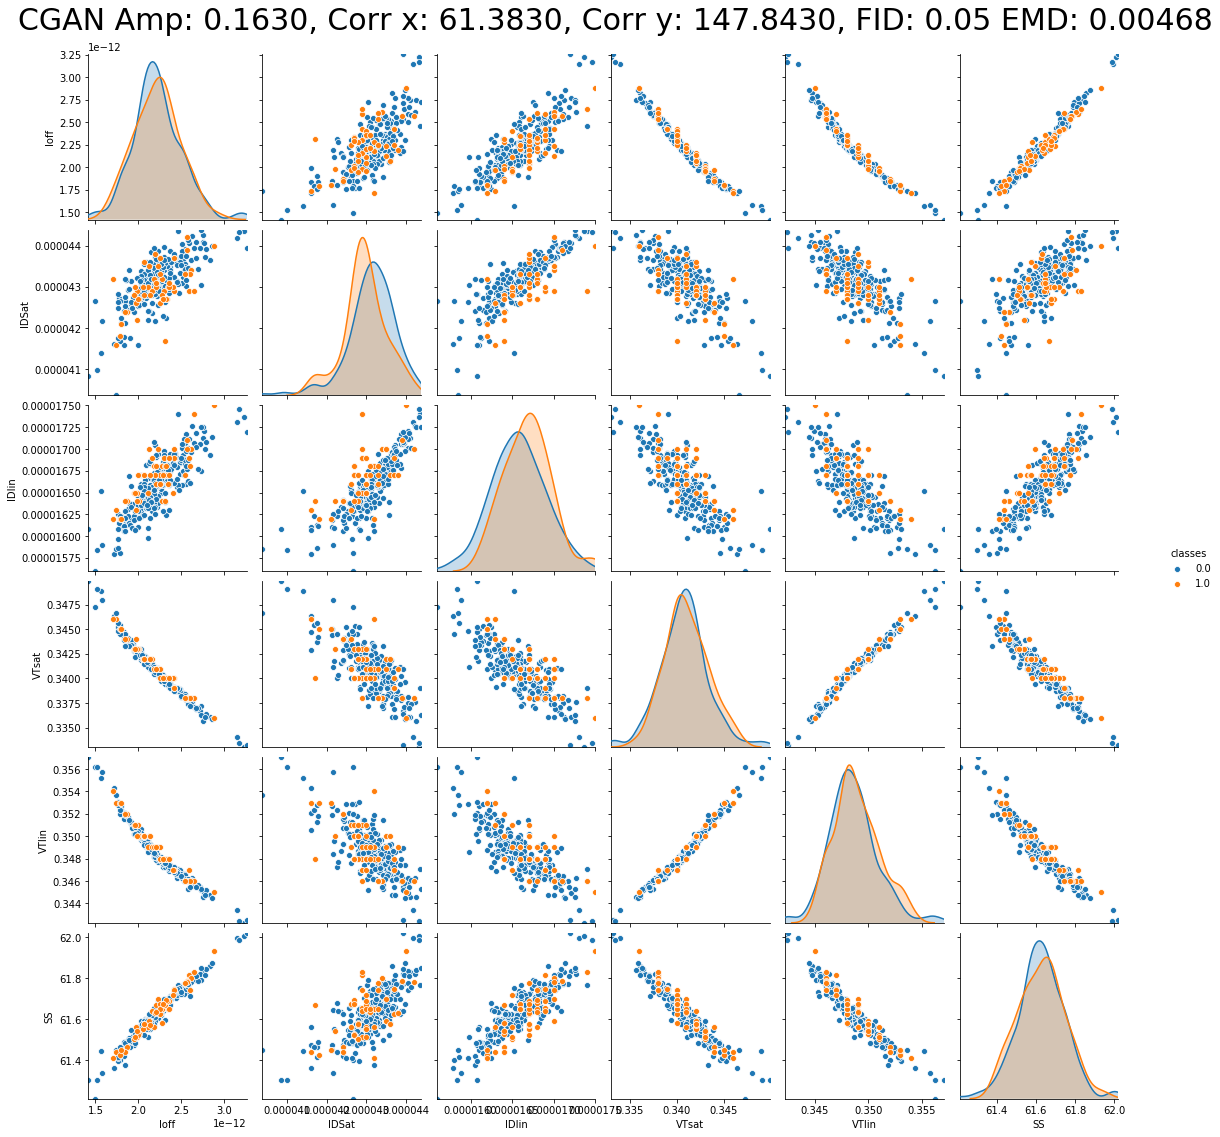

In [147]:
import seaborn as sns

# min, max for generated Y value ( used for scatter plot limit standard )

min_list = total_matrix_plot.min(axis=0)
max_list = total_matrix_plot.max(axis=0)
print("minimum y value for each varaible:", min_list)
print("maximum y value for each varaible:", max_list)

X = dataset.test_X_per_cycle[factor]

print("X input", X)

g = sns.pairplot(df1, hue = 'classes')
for i in range(6):
    g.fig.suptitle("CGAN Amp: {:.4f}, Corr x: {:.4f}, Corr y: {:.4f}, FID: {:.2f} EMD: {:.5f}".format(X[0], X[1], X[2], FID_score_list[factor], EMD_score_list[factor]), y=1.04, fontsize=30)
    g.axes[i,i].set_xlim((min_list[i],max_list[i]))
    g.axes[i,i].set_ylim((min_list[i],max_list[i]))
plt.show()

# SCATTER PLOT two variable

check sample_num:  250


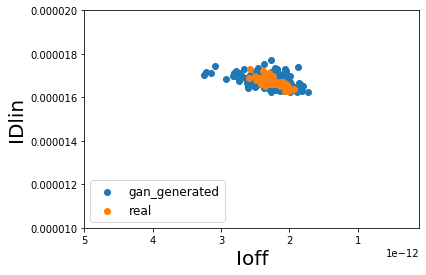

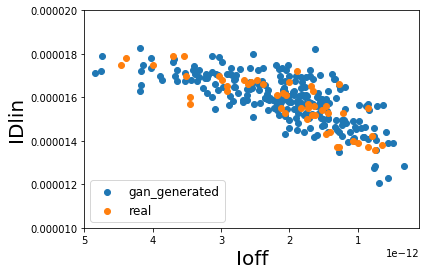

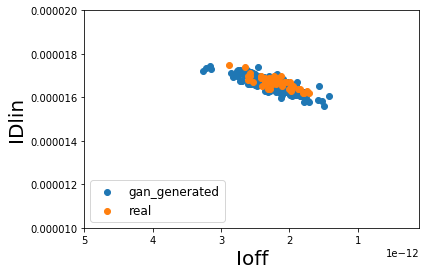

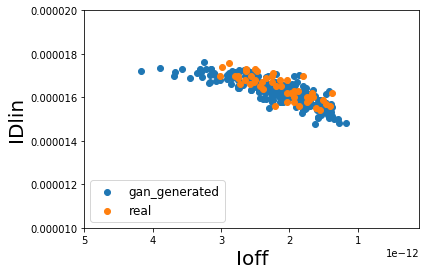

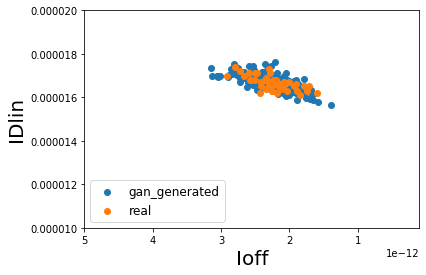

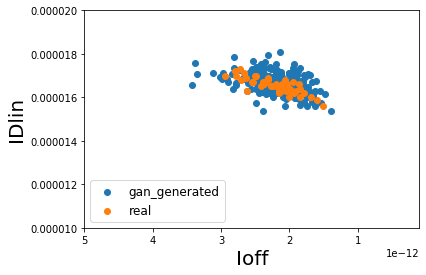

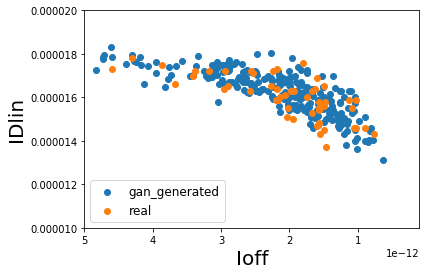

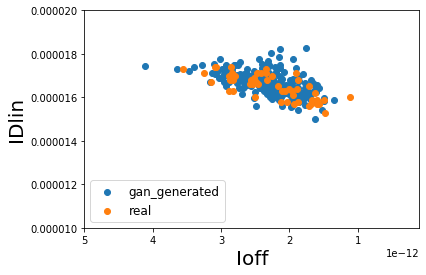

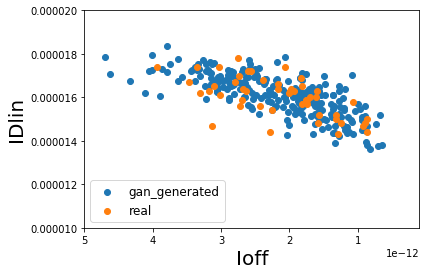

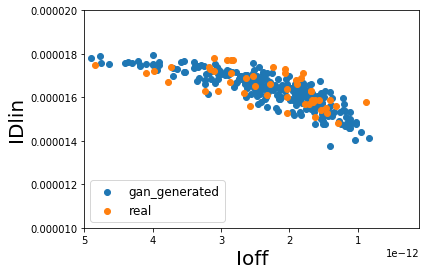

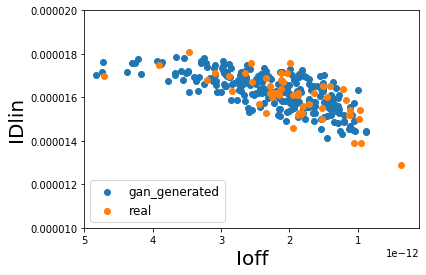

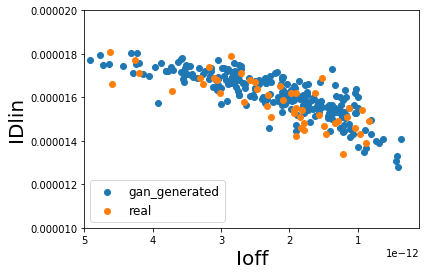

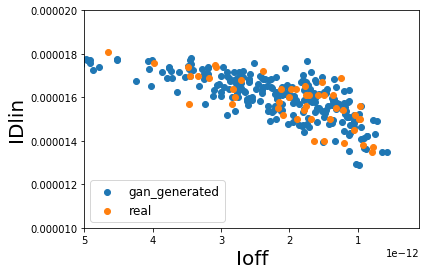

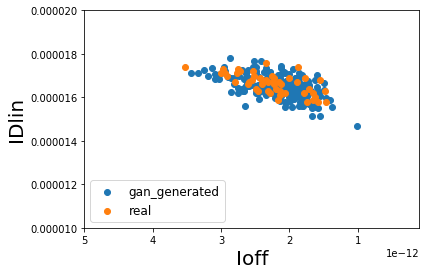

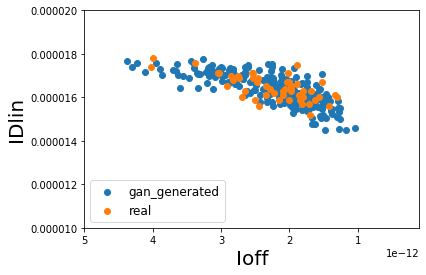

In [148]:
# ( Ioff / IDlin )

print("check sample_num: ", sample_num)

factor_plot = sample_num // num_in_cycle
for idx in range(15):
    start = num_in_cycle * idx
    end = num_in_cycle * (idx+1)
    plt.scatter(total_result[start*factor_plot:end*factor_plot,0],total_result[start*factor_plot:end*factor_plot,2], label='gan_generated')
    plt.scatter(real[start:end,0],real[start:end,2], label='real')
    plt.xlim(5e-12, 1e-13)
    plt.ylim(1e-5, 2e-5)
    plt.legend(loc='lower left', fontsize=12)
    plt.xlabel("Ioff", fontsize=20)
    plt.ylabel("IDlin", fontsize=20)
    plt.show()

check sample_num:  250


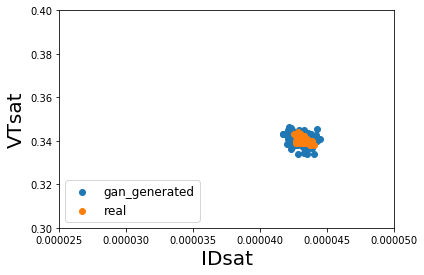

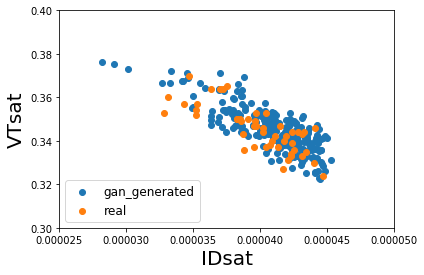

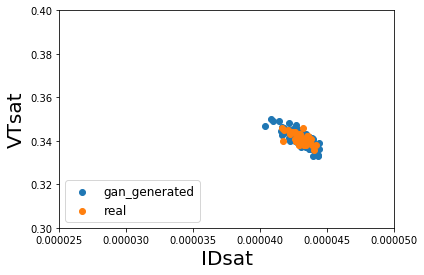

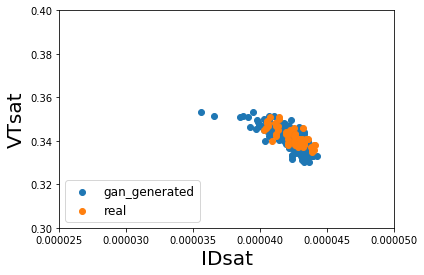

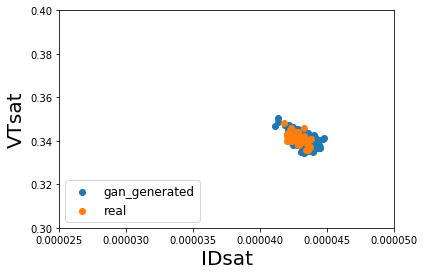

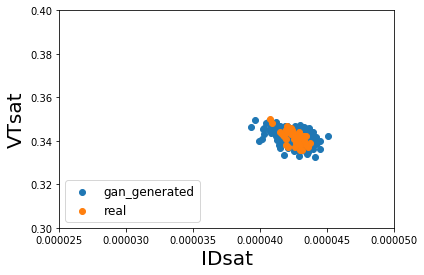

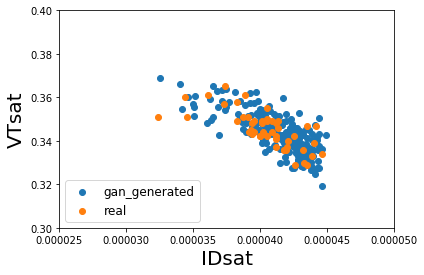

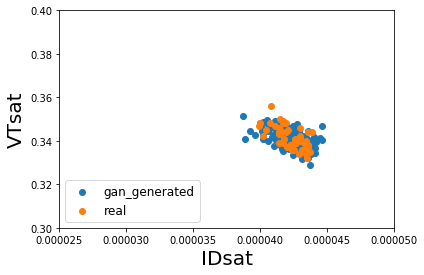

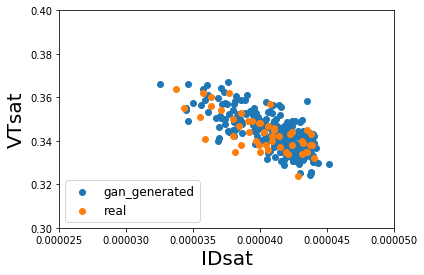

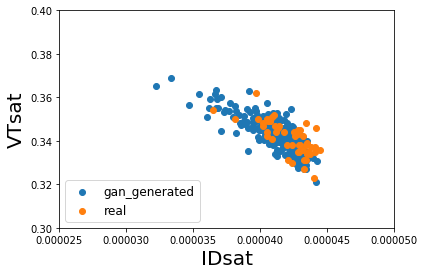

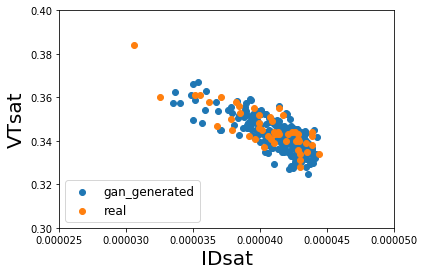

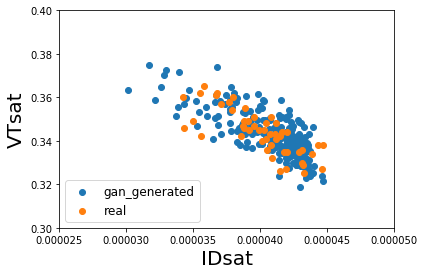

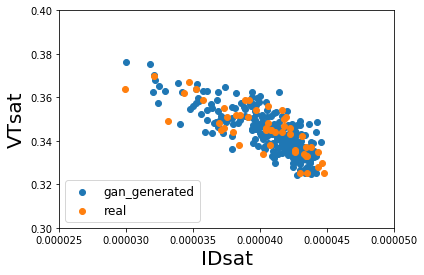

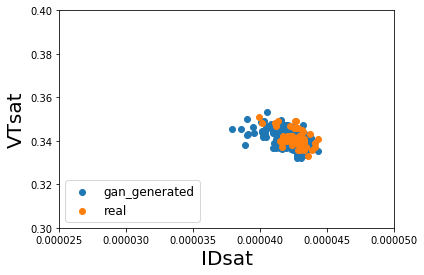

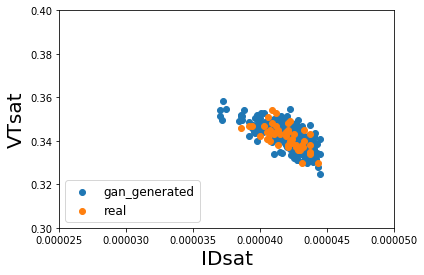

In [149]:
# ( IDsat / VTsat )

print("check sample_num: ", sample_num)

factor = sample_num // num_in_cycle
for idx in range(15):
    start = num_in_cycle * idx
    end = num_in_cycle * (idx+1)
    plt.scatter(total_result[start*factor_plot:end*factor_plot,1],total_result[start*factor_plot:end*factor_plot,3], label='gan_generated')
    plt.scatter(real[start:end,1],real[start:end,3], label='real')
    plt.xlim(2.5e-5, 5e-5)
    plt.ylim(3e-1, 4e-1)
    plt.legend(loc='lower left', fontsize=12)
    plt.xlabel("IDsat", fontsize=20)
    plt.ylabel("VTsat", fontsize=20)
    plt.show()

# SPECIFIC Test data (additional)

In [150]:
name = '2020_LER_20200922_testset.csv'
datatype = 'n'

dataset_test = sample_utils.get_dataset_test(name, datatype)
num_in_cycle = num_in_cycle=[232, 289, 277, 253, 255] 
num_of_cycle = 5

# real
real_test = dataset_test.test_Y

print(real_test)


============ Data load =============
X data shape:  (1306, 5) X per cycle data shape: (5, 5)
Y data shape:  (1306, 6) Y per cycle data shape: (5, 6)
any nan in X?:  []
any nan in Y?:  []
[[1.9600e-12 4.2400e-05 1.6200e-05 3.4300e-01 3.5300e-01 6.1501e+01]
 [6.1400e-13 3.6300e-05 1.4500e-05 3.7000e-01 3.7700e-01 6.0804e+01]
 [7.4400e-13 3.1800e-05 1.3900e-05 3.7000e-01 3.7400e-01 6.1200e+01]
 ...
 [1.4800e-12 3.8900e-05 1.6100e-05 3.5100e-01 3.5800e-01 6.1429e+01]
 [1.0500e-12 3.6000e-05 1.4200e-05 3.5700e-01 3.6400e-01 6.1047e+01]
 [2.0000e-12 3.9100e-05 1.5800e-05 3.4600e-01 3.5300e-01 6.1761e+01]]


232


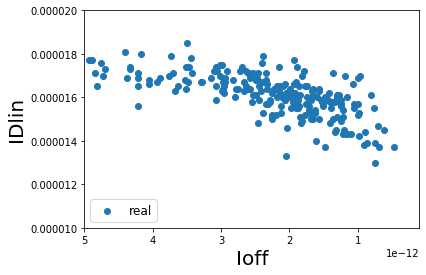

289


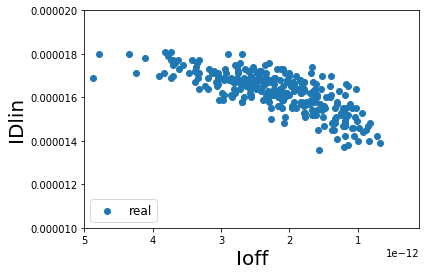

277


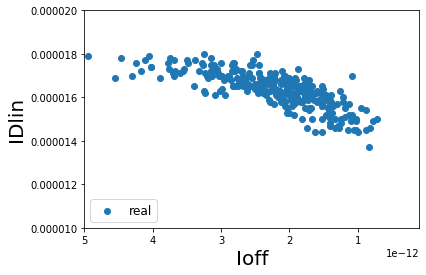

253


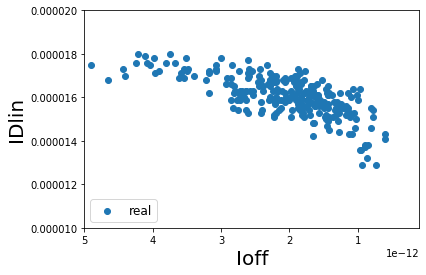

255


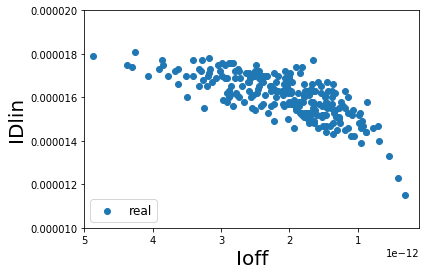

In [151]:
# TEST SET Visualize

import pandas as pd
import numpy as np

idx = 0

for i in range(num_of_cycle): 
    print(num_in_cycle[i])
    plt.scatter(real_test[idx:idx+num_in_cycle[i],0],real_test[idx:idx+num_in_cycle[i],2], label='real')
    plt.xlim(5e-12, 1e-13)
    plt.ylim(1e-5, 2e-5)
    plt.legend(loc='lower left', fontsize=12)
    plt.xlabel("Ioff", fontsize=20)
    plt.ylabel("IDlin", fontsize=20)
    plt.show()
    
    idx += num_in_cycle[i]


In [152]:
############################################### CHANGE HERE ##################################################

# type your result name

total_test_name = 'test_specificdate_20200927_data_n_model_mlp_gan1_seed_0_lr_5e-05_0.0001_0.0005_hidden_dim_100_50_batch_size_32_epoch_1000_200_noise_d_100_sample_num_500_pdrop_0.9.npy'

##############################################################################################################

total_test_result = np.load(total_test_name, allow_pickle=True)

test_sample_num = int(len(total_test_result)/5)
print("GENERATED SAMPLE shape: ",total_test_result.shape)
print("GENERATED SAMPLE NUM:", test_sample_num)

# checking nan value
print("any nan in real?: ", np.argwhere(np.isnan(real_test)))
print("any nan in generated?: ", np.argwhere(np.isnan(total_test_result)))

GENERATED SAMPLE shape:  (2500, 6)
GENERATED SAMPLE NUM: 500
any nan in real?:  []
any nan in generated?:  []


In [153]:
import pandas as pd
import numpy as np

############################################### CHANGE HERE ##################################################

# type the X index of test sample ( 0 ~ 5 )

factor = 4

##############################################################################################################
"""
for i in range(6):
    print(np.min(total_result[:,i]))
    print(np.max(total_result[:,i]))
    print(np.min(real[:,i]))
    print(np.max(real[:,i]))
"""

# generated sample
print(sum(num_in_cycle[:factor]),sum(num_in_cycle[:factor])+num_in_cycle[factor])
test_gan_matrix_plot = total_test_result[factor * test_sample_num:(factor+1)*test_sample_num]
print("Generated sample shape:", test_gan_matrix_plot.shape)

# real sample
test_real_matrix_plot = real_test[sum(num_in_cycle[:factor]):sum(num_in_cycle[:factor])+num_in_cycle[factor]]
print("real sample shape:", test_real_matrix_plot.shape)
print()

# Assigning class(generated: 0, real:1 ) for visualization

print("Assigning class for visualization (generated: 0, real:1 )")

test_gan_cls = np.zeros((test_sample_num, 1))
print("generated sample class shape:", test_gan_cls.shape)
test_real_cls = np.ones((num_in_cycle[factor], 1))
print("real sample class shape:", test_real_cls.shape)

test_temp1 = np.hstack([test_gan_matrix_plot, test_gan_cls])
test_temp2 = np.hstack([test_real_matrix_plot, test_real_cls])

# TOTAL PANDAS DATA
total_test_matrix_plot = np.vstack([test_temp1, test_temp2])
# print(total_matrix_plot.shape)

# A: Ioff, B: IDSat, C: IDlin, D: VTsat, E:VTlin, F:SS, G: classes
df1_test = pd.DataFrame(total_test_matrix_plot, columns=['Ioff', 'IDSat',  'IDlin',  'VTsat', 'VTlin', 'SS', 'classes'])
# print(df1)

print(df1_test)


1051 1306
Generated sample shape: (500, 6)
real sample shape: (255, 6)

Assigning class for visualization (generated: 0, real:1 )
generated sample class shape: (500, 1)
real sample class shape: (255, 1)
             Ioff     IDSat     IDlin     VTsat     VTlin         SS  classes
0    9.477339e-13  0.000038  0.000014  0.359820  0.368866  60.982244      0.0
1    9.677851e-13  0.000039  0.000014  0.356883  0.366802  60.990132      0.0
2    3.279840e-12  0.000043  0.000017  0.332934  0.343874  62.063656      0.0
3    1.642636e-12  0.000041  0.000016  0.346798  0.356324  61.425117      0.0
4    1.477712e-12  0.000043  0.000014  0.347618  0.359371  61.319929      0.0
..            ...       ...       ...       ...       ...        ...      ...
750  2.530000e-12  0.000042  0.000017  0.339000  0.348000  61.908000      1.0
751  1.950000e-12  0.000042  0.000016  0.344000  0.351000  61.595000      1.0
752  1.480000e-12  0.000039  0.000016  0.351000  0.358000  61.429000      1.0
753  1.050000e-12

minimum y value for each varaible: [3.02000000e-13 2.80000000e-05 1.15000000e-05 3.19012333e-01
 3.32371717e-01 6.07463704e+01 0.00000000e+00]
maximum y value for each varaible: [6.53386048e-12 4.50000000e-05 1.83114694e-05 3.94000000e-01
 3.97000000e-01 6.32492261e+01 1.00000000e+00]
X input [ 0.637 69.149 65.33   1.     0.   ]


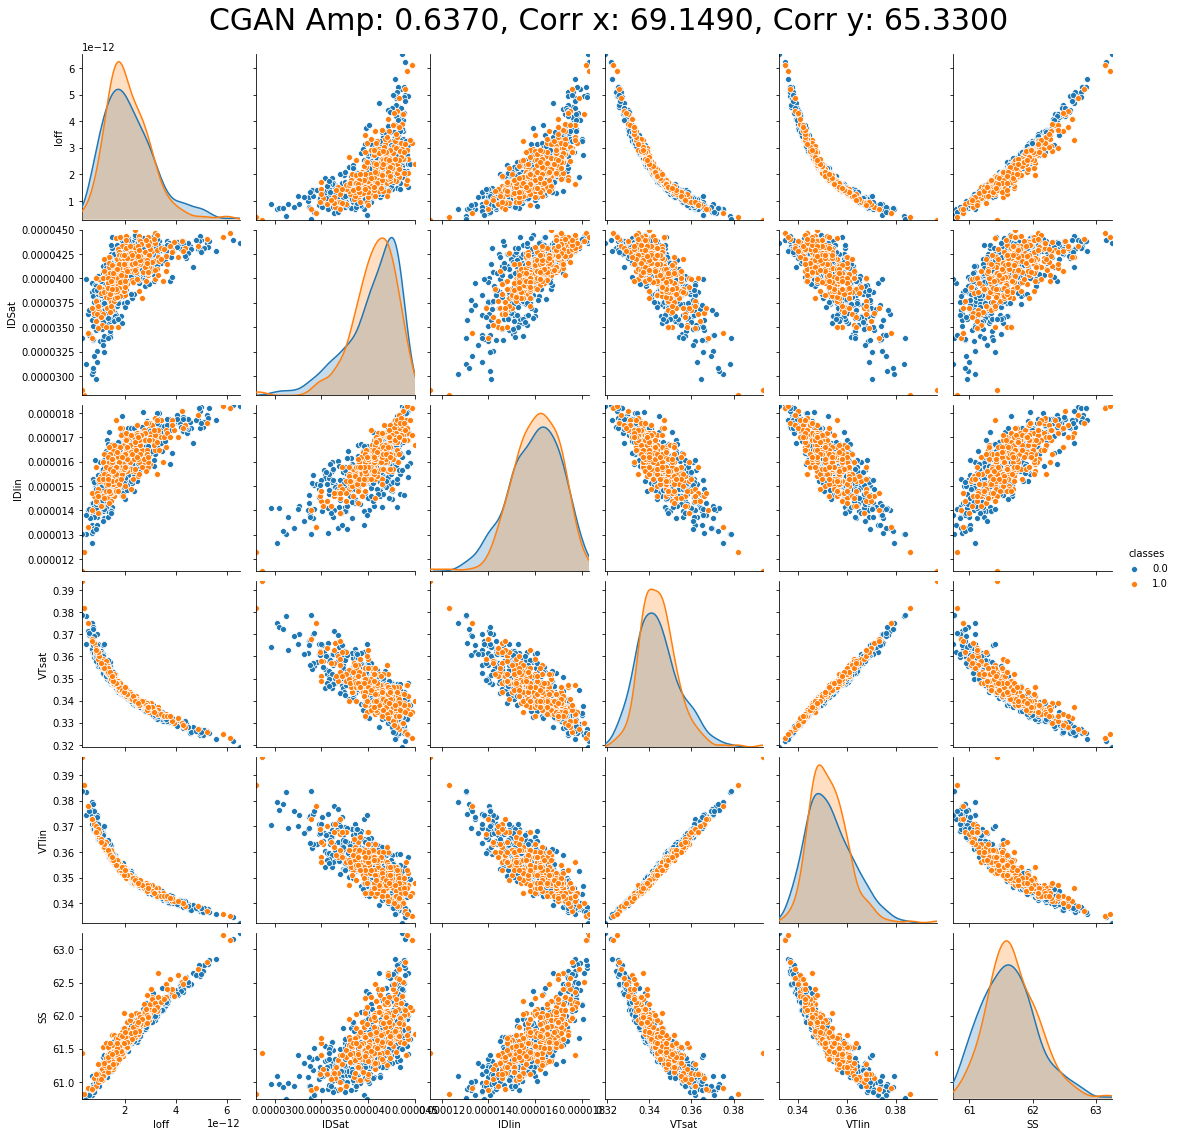

In [154]:
# min, max for generated Y value ( used for scatter plot limit standard )

test_min_list = total_test_matrix_plot.min(axis=0)
test_max_list = total_test_matrix_plot.max(axis=0)
print("minimum y value for each varaible:", test_min_list)
print("maximum y value for each varaible:", test_max_list)

X_test = dataset_test.test_X_per_cycle[factor]

print("X input", X_test)

g = sns.pairplot(df1_test, hue = 'classes')
for i in range(6):
    g.fig.suptitle("CGAN Amp: {:.4f}, Corr x: {:.4f}, Corr y: {:.4f}".format(X_test[0], X_test[1], X_test[2]), y=1.04, fontsize=30)
    g.axes[i,i].set_xlim((test_min_list[i],test_max_list[i]))
    g.axes[i,i].set_ylim((test_min_list[i],test_max_list[i]))
plt.show()